In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [66]:
from mpl_toolkits.mplot3d import axes3d

In [108]:
N_HANDS_TO_PLAY=5*10**6

#--
# implement hands of black jack
#--

nStates          = np.prod([21-12+1,13,2]);
allStatesRewSum  = np.zeros((nStates,1));
allStatesNVisits = np.zeros((nStates,1)); 
mc_value_fn = np.zeros((nStates,1))

for hi in xrange(N_HANDS_TO_PLAY):  
    stateseen = []
    deck = shufflecards()
    # the player gets the first two cards: 
    p = deck[:2]
    deck = deck[2:] 
    # the dealer gets the next two cards (and shows his first card): 
    d = deck[:2]
    deck = deck[2:]
    dhv = handValue(d)[0]
    cardShowing = d[0] 
    # accumulate/store the first state seen: 
    stateseen.append(stateFromHand(p, cardShowing))
    phv = handValue(p)[0]
    # implement the policy of the player (hit until we have a hand value of 20 or 21): 
    while phv < 20:
        p = np.hstack((p, deck[0]))
        deck = deck[1:] # HIT
        stateseen.append(stateFromHand(p, cardShowing))
        phv = handValue(p)[0]       
    # implement the policy of the dealer (hit until we have a hand value of 17): 
    while dhv < 17:
        d = np.hstack((d, deck[0])) 
        deck = deck[1:] # HIT
        dhv = handValue(d)[0] 
    # determine the reward for playing this game:
    rew = determineReward(phv,dhv)
    # accumulate these values used in computing global statistics: 
    for si in range(len(stateseen)):
        if( (stateseen[si][0] >= 12) and (stateseen[si][0]<=21) ): # we don't count "initial" and terminal states
            #[stateseen(si,1)]
            #[stateseen(si,1)-12+1, stateseen(si,2), stateseen(si,3)+1]
            #print stateseen[si][0]-12+1, stateseen[si][1], stateseen[si][2]
            indx = np.ravel_multi_index((stateseen[si][0]-12+1-1, stateseen[si][1]-1, stateseen[si][2]), (10,13,2) ) 
            allStatesRewSum[indx]  = allStatesRewSum[indx]+rew 
            allStatesNVisits[indx] = allStatesNVisits[indx]+1.0 


mc_value_fn[np.where(allStatesNVisits !=0)] = (allStatesRewSum[np.where(allStatesNVisits !=0)]
                                               /allStatesNVisits[np.where(allStatesNVisits !=0)])

mc_value_fn = np.reshape(mc_value_fn, [10,13,2])

No usable ace


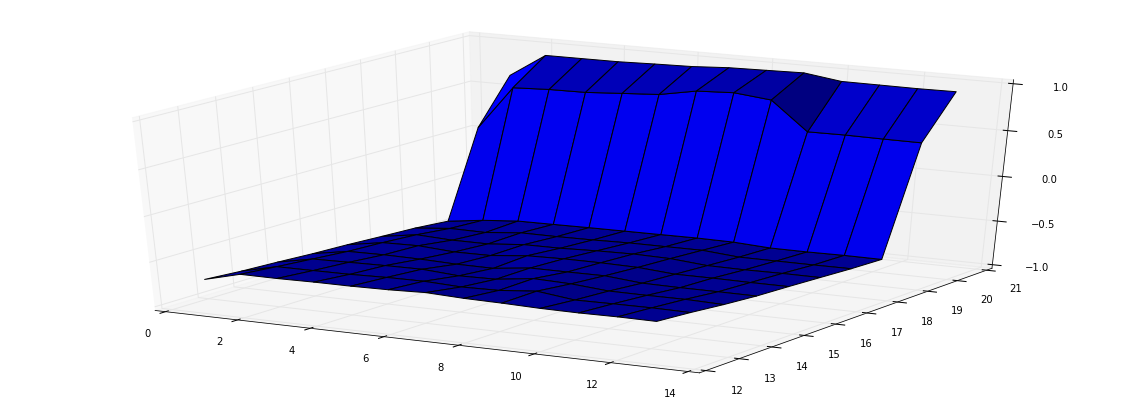

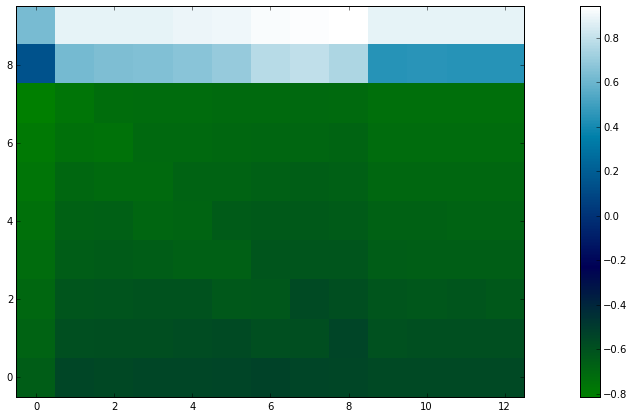

Usable ace


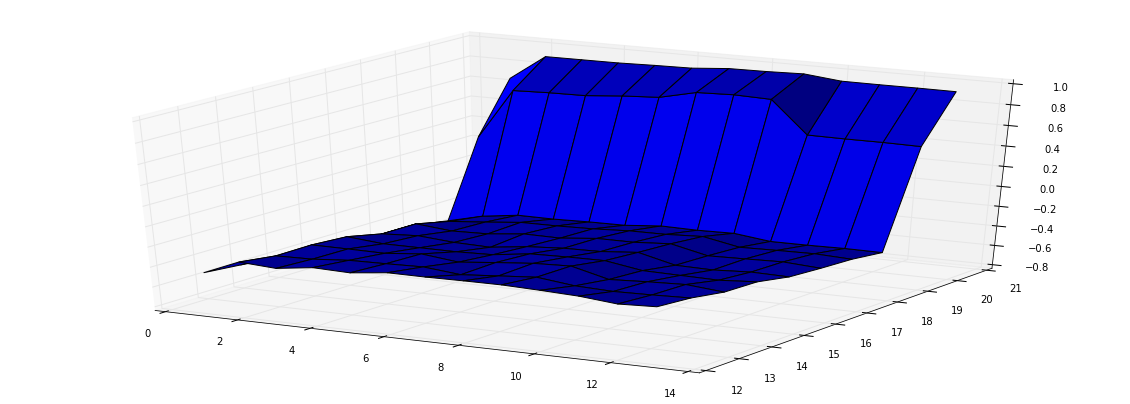

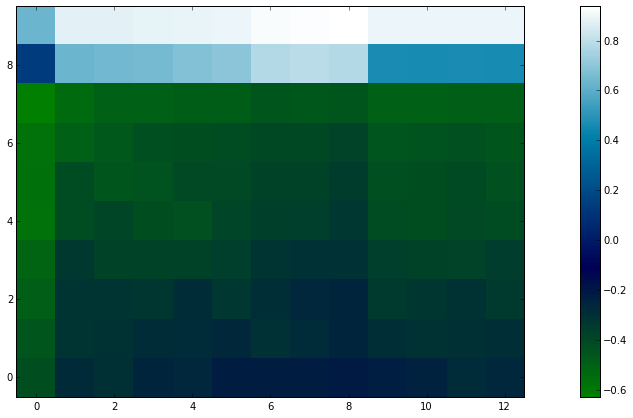

In [109]:
print 'No usable ace'
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = np.tile(np.arange(1,14), (10,1))
Y = np.repeat(np.arange(12, 22).reshape(10,1),13, axis=1) 

Z = mc_value_fn[:,:,0]
ax.plot_surface(X, Y, Z, rstride=1, cstride=1)
figsize(20,7)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(Z, interpolation='nearest', cmap=plt.cm.ocean, origin='left')
plt.colorbar()
plt.show()  

print 'Usable ace'
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = np.tile(np.arange(1,14), (10,1))
Y = np.repeat(np.arange(12, 22).reshape(10,1),13, axis=1) 

Z = mc_value_fn[:,:,1]
ax.plot_surface(X, Y, Z, rstride=1, cstride=1)
figsize(20,7)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(Z, interpolation='nearest', cmap=plt.cm.ocean, origin='left')
plt.colorbar()
plt.show()  
#fn=sprintf('state_value_fn_nua_%d_mesh.eps',N_HANDS_TO_PLAY); saveas( gcf, fn, 'eps2' );

In [37]:
def determineReward(phv,dhv):
    if phv > 21: # player went bust
        rew = -1 
    elif dhv > 21: # dealer went bust
        rew = +1 
    elif phv == dhv: # a tie
      rew = 0 
    elif phv > dhv: # the larger hand wins
      rew = +1 
    else:
      rew = -1
    return rew


In [38]:
def shufflecards():
    deck = np.random.permutation(range(1,53))
    return deck

In [41]:
def handValue(hand):
    # compute 1:13 indexing for each card: 
    values = [np.mod(h - 1, 13 )+1 for h in hand] 
    # map face cards (11,12,13)'s to 10's:
    values = np.minimum(values, 10)
    sv     = sum(values) 
    # Promote soft ace
    if (np.any(values==1)) and (sv<=11):
        sv = sv + 10
        usableAce = 1 
    else:
        usableAce = 0
    hv = sv 
    return hv, usableAce

In [1]:
def stateFromHand(hand,cardShowing):
    [hv,usableAce] = handValue(hand)
    cardShowing = np.mod(cardShowing - 1, 13) + 1
    st = [hv, cardShowing, usableAce] 
    return st